# Test `tracer_thalweg_and_surface` Module

Render figure object produced by the `nowcast.figures.research.tracer_thalweg_and_surface` module.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker
to help ensure that the module will work in the nowcast production context.

In [27]:
# reload lets us pull in changes from modules that we edit
from importlib import reload

In [33]:
# imports for set-up similar to what make_plots worker does
import io
import os
from pathlib import Path

import arrow
import cmocean
import netCDF4 as nc
import scipy.io as sio
import yaml

from salishsea_tools import nc_tools, tidetools

from nowcast.figures.research import tracer_thalweg_and_surface

In [18]:
%matplotlib inline

## Simulate Nowcast System Config

The `config` multiline string contains the pieces of `nowcast/config/nowcast.yaml`
that are needed to set up the conditions as `nowcast.workers.make_plots` does
before calling the figure module `make_figure()` function.

The `yaml.load()` call at the bottom of the cell converts the string into a `config` dict.

In [19]:
config = '''
    run_types:
        nowcast-green:
            bathymetry: /results/nowcast-sys/NEMO-forcing/grid/bathy_meter_SalishSea2.nc
            mesh_mask: /results/nowcast-sys/NEMO-forcing/grid/mesh_mask_SalishSea2.nc

    run:
        results_archive:
            nowcast-green: /results/SalishSea/nowcast-green/
'''

config = yaml.load(io.StringIO(config))

In [20]:
run_date = arrow.get('2016-04-01')
run_type = 'nowcast-green'

dmy = run_date.format('DDMMMYY').lower()
yyyymmdd = run_date.format('YYYYMMDD')

results_home = Path(config['run']['results_archive'][run_type])
results_dir = results_home/dmy

In [23]:
bathymetry = nc.Dataset(config['run_types'][run_type]['bathymetry'])
bathy, lons, lats = tidetools.get_bathy_data(bathymetry)

mesh_mask = nc.Dataset(config['run_types']['nowcast-green']['mesh_mask'])

coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')

ptrc_T = nc.Dataset(os.fspath(results_dir/f'SalishSea_1h_{yyyymmdd}_{yyyymmdd}_ptrc_T.nc'))
tracer_grid = ptrc_T.variables['PHY2']

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

The `reload()` calls reload imported modules so that any edits you have made will take effect here.

The `make_figure()` call should be the same as goes in the `make_plots` worker module.

46.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


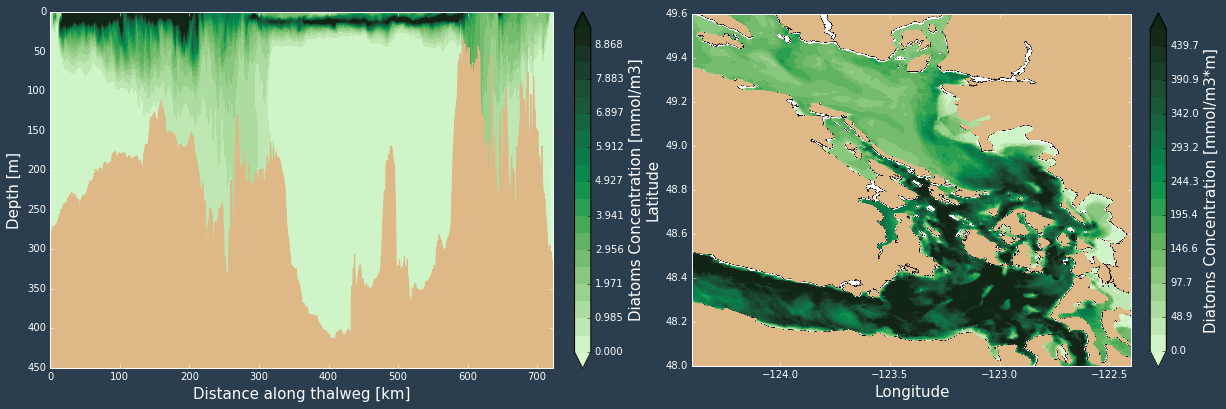

In [34]:
%%timeit -n1 -r1

reload(tracer_thalweg_and_surface)

fig = tracer_thalweg_and_surface.make_figure(
    tracer_grid, bathy, lons, lats, mesh_mask, coastline, cmap=cmocean.cm.algae,
    depth_integrated=True
)

In [30]:
%pdb

Automatic pdb calling has been turned OFF
